# Experiments 2 and 3: Performance Comparison and Hyperparameter Assessment

**Experiment 2: Performance Comparison (Linear vs. Nonlinear)**
- This experiment compares the performance of **Linear NOTEARS** and **Nonlinear NOTEARS** under varying parameter settings
- It evaluates the algorithms' accuracy using metrics such as **False Discovery Rate (FDR)**, **False Positive Rate (FPR)**, **True Positive Rate (TPR)**, and **Structural Hamming Distance (SHD)**
- The goal is to investigate how these methods perform on both **standardized** and **non-standardized** data

**Experiment 3: Hyperparameter Assessment:**
- This experiment critically examines the impact of two key hyperparameters: **lambda_1** (regularization parameter) and the **threshold** used to binarize the adjacency matrix
- The experiment evaluates how these hyperparameters affect the accuracy metrics (**TPR** and **SHD**) for Linear NOTEARS

---

### Table of Contents:
- <a href='#1'>1. Experimental Setup </a>

- <a href='#2'>2. Data & Functions </a>
    - <a href='#2.1'>2.1 Load Data </a>
    - <a href='#2.2'>2.2 Helper Functions </a>

- <a href='#3'>3. Experiment 2: Linear vs Nonlinar NOTEARS</a>
    - <a href='#3.1'>3.1 Experiment 2.1: Linear vs Nonlinear under Standardization</a> 
    - <a href='#3.2'>3.2 Experiment 2.2: Linear vs Nonlinear on Linear & Nonlinear Data</a> 

- <a href='#4'>4. Experiment 3: Hyperparameter Assessment</a>


# <a id='1'>1. Experimental Setup</a>
----

**Experiment 2: Performance Comparison (Linear vs. Nonlinear)**
- This experiment investigates the performance of **Linear NOTEARS** and **Nonlinear NOTEARS** in two parts:
   1. **Experiment 2.1**: Performance comparison under different parameter settings.
      - **Parameters**: Number of variables ($d = 10$), sparsity ($s_0 = 20$), 1000 samples ($n = 1000$), and Erdős-Rényi ($ER$) graph type.
      - **Standardization**: Results are compared for both standardized and non-standardized data.
      - **Noise Type**: Gaussian noise with a scale of $1.0$.
      - **Metrics**: False Discovery Rate (FDR), False Positive Rate (FPR), True Positive Rate (TPR), and Structural Hamming Distance (SHD).

   2. **Experiment 2.2**: Performance comparison on linear and nonlinear data generated by different Structural Equation Models (SEMs).
      - **Data Types**: Linear SEM with Gaussian noise and Nonlinear SEM with MLP-based relationships.
      - **Parameters**: Same as in Experiment 2.1.
      - **Hyperparameters**: Regularization parameter $\lambda_1 = 0.01$ for both methods, with an additional $\lambda_2 = 0.01$ for Nonlinear NOTEARS.
      - **Threshold**: $0.3$ for binarizing adjacency matrices.

**Experiment 3: Hyperparameter Assessment**
- This experiment evaluates the effect of two key hyperparameters on the performance of Linear NOTEARS:
- $\lambda_1$: Controls the sparsity of the learned adjacency matrix. Explored over a range of values $\lambda_1 \in [10^{-3}, 10^{0}]$ (logarithmic scale with 10 points).
- **Threshold**: Used for binarizing the adjacency matrix. Explored over a range of values $[0.1, 0.75]$ in increments of $0.05$.

- The experiment consists of two scenarios:
   1. **Scenario A**: Vary $\lambda_1$ with fixed thresholds ($0.2$, $0.4$, $0.6$).
   2. **Scenario B**: Vary thresholds with fixed $\lambda_1$ values ($0.01$, $0.05$, $0.1$).

- **Data**: Simulated using an Erdős-Rényi ($ER$) graph with $d = 10$ variables, $s_0 = 20$ edges, and Gaussian noise (scale $1.0$). 100 samples ($n = 100$) are used.
- **Metrics**: True Positive Rate (TPR) and Structural Hamming Distance (SHD).


# <a id='2'>2. Data & Functions</a>
---

## <a id='2.1'>2.1 Load data</a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
from notears.nonlinear import NotearsMLP, notears_nonlinear
from notears.utils import (
    set_random_seed,
    simulate_dag,
    simulate_linear_sem,
    simulate_nonlinear_sem,
    count_accuracy
)

# Import the linear and nonlinear experiment functions
from notears_linear import run_linear_notears_experiment
from notears_nonlinear import run_nonlinear_notears_experiment

# Configure plotting style
sns.set_style("whitegrid")

# Define a color palette
COLOR_PALETTE = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Define folder for saving plots
PLOT_FOLDER = "plots"
os.makedirs(PLOT_FOLDER, exist_ok=True)

# For reproducibility (set your preferred seed):
SEED = 42
set_random_seed(SEED)

## <a id='2.2'>2.2 Helper Functions</a>

**General Plot functions:**

In [2]:
def plot_metric_bars(df, x_col, hue_col, metric, ax, y_lim=None, title=None):
    """
    Helper function to create a barplot of a given metric with optional y-limit.
    """
    palette = sns.color_palette(COLOR_PALETTE[:df[hue_col].nunique()])
    sns.barplot(data=df, x=x_col, y=metric, hue=hue_col, ax=ax, palette=palette)
    ax.set_title(title if title else f"{metric.upper()} by {x_col} and {hue_col}", fontsize=14)
    ax.set_xlabel(x_col.capitalize(), fontsize=12)
    ax.set_ylabel(metric.upper(), fontsize=12)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    if metric == "fdr":
         ax.legend(title=hue_col.capitalize(), fontsize=11, title_fontsize=11)
    else:
        ax.get_legend().remove()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)


def plot_scatter(df, x_col, y_col, hue_col, ax, title=None):
    """
    Helper function for scatterplot of two variables with color hue.
    """
    palette = sns.color_palette(COLOR_PALETTE[:df[hue_col].nunique()])
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, ax=ax, s=100, palette=palette)
    ax.set_title(title if title else f"{y_col.upper()} vs. {x_col.capitalize()}", fontsize=14)
    ax.set_xlabel(x_col.capitalize(), fontsize=12)
    ax.set_ylabel(y_col.upper(), fontsize=12)
    if y_col == "tpr":
        ax.legend(title=hue_col.capitalize(), fontsize=11, title_fontsize=11)
    else:
        ax.get_legend().remove()
    ax.grid(True, linestyle='--', alpha=0.7)

**Specific Plot functions:**

In [3]:
def plot_experiment2_2(df_results, title):
    """
    Create a 2x2 barplot grid for FDR, FPR, TPR, and SHD comparing
    linear vs. nonlinear NOTEARS on both linear and nonlinear data.
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle(f"Linear vs. Nonlinear NOTEARS on Linear and Nonlinear Data", fontsize=14, y=0.95)

    metrics = ["fdr", "fpr", "tpr", "shd"]
    full_titles = {
        "fdr": "FDR",
        "fpr": "FPR",
        "tpr": "TPR",
        "shd": "SHD"
    }

    y_limits = {
        "fdr": (0, 1),
        "fpr": (0, 1),
        "tpr": (0, 1),
        "shd": (0, df_results["shd"].max() + 1)
    }
    palette = sns.color_palette(COLOR_PALETTE[:df_results['method'].nunique()])
    for ax, metric in zip(axes.flatten(), metrics):
        sns.barplot(
            data=df_results,
            x="data_type",
            y=metric,
            hue="method",
            ax=ax,
            palette=palette
        )
        ax.set_title(full_titles[metric], fontsize=14)
        ax.set_xlabel("Data Type", fontsize=12)
        ax.set_ylabel(metric.upper(), fontsize=12)
        ax.set_ylim(y_limits[metric])
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Show legend only on the first subplot
        if metric == "fdr":
            ax.legend(title="Method", fontsize=11, title_fontsize=11)
        else:
            ax.get_legend().remove()

        # Add annotations
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", fontsize=9, padding=3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(os.path.join(PLOT_FOLDER, title), dpi=300)
    plt.show()


def plot_experiment3(df_fix_thr, df_fix_lam):
    """
    Plot the results of the hyperparameter assessment experiment.
    
    Parameters:
        df_fix_thr (pd.DataFrame): Results for Scenario A (vary lambda, fix thresholds).
        df_fix_lam (pd.DataFrame): Results for Scenario B (vary threshold, fix lambda).
    """
    print("\n--- Generating Plots ---")

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle("Linear NOTEARS: Hyperparameter Assessment", fontsize=14, y=0.95)
    palette = sns.color_palette(COLOR_PALETTE[:df_fix_thr['threshold'].nunique()])

    # A) Scenario A - TPR vs. lambda
    ax = axes[0, 0]
    sns.lineplot(
        data=df_fix_thr,
        x="lambda1",
        y="tpr",
        hue="threshold",
        marker="o",
        ax=ax,
        palette=palette
    )
    ax.set_xscale("log")
    ax.set_title("TPR vs. lambda (Fixed Thresholds)", fontsize=14)
    ax.set_xlabel("lambda (log scale)", fontsize=12)
    ax.set_ylabel("TPR", fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="Threshold", fontsize=11, title_fontsize=11)

    # B) Scenario A - SHD vs. lambda1
    ax = axes[0, 1]
    sns.lineplot(
        data=df_fix_thr,
        x="lambda1",
        y="shd",
        hue="threshold",
        marker="o",
        ax=ax,
        palette=palette
    )
    ax.set_xscale("log")
    ax.set_title("SHD vs. lambda (Fixed Thresholds)", fontsize=14)
    ax.set_xlabel("lambda (log scale)", fontsize=12)
    ax.set_ylabel("SHD", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="Threshold", fontsize=11, title_fontsize=11)
    palette = sns.color_palette(COLOR_PALETTE[:df_fix_lam['lambda1'].nunique()])

    # C) Scenario B - TPR vs. threshold
    ax = axes[1, 0]
    sns.lineplot(
        data=df_fix_lam,
        x="threshold",
        y="tpr",
        hue="lambda1",
        marker="o",
        ax=ax,
        palette=palette
    )
    ax.set_title("TPR vs. Threshold (Fixed lambda)", fontsize=14)
    ax.set_xlabel("Threshold", fontsize=12)
    ax.set_ylabel("TPR", fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="lambda", fontsize=11, title_fontsize=11)

    # D) Scenario B - SHD vs. threshold
    ax = axes[1, 1]
    sns.lineplot(
        data=df_fix_lam,
        x="threshold",
        y="shd",
        hue="lambda1",
        marker="o",
        ax=ax,
        palette=palette
    )
    ax.set_title("SHD vs. Threshold (Fixed lambda)", fontsize=14)
    ax.set_xlabel("Threshold", fontsize=12)
    ax.set_ylabel("SHD", fontsize=12)
    max_shd = df_fix_lam["shd"].max()
    ax.set_ylim(0, max_shd + 1)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="lambda", fontsize=11, title_fontsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(PLOT_FOLDER, 'Exp_3.png'), dpi=300)
    plt.show()


# <a id='3'>3. Experiment 2: Linear vs Nonlinar NOTEARS</a>
---

## <a id='3.1'>3.1 Experiment 2.1: Linear vs Nonlinear under Standardization</a>

In [4]:
def experiment2_1():
    """
    Experiment 2.1: Compare performance of Linear vs. Nonlinear NOTEARS
    under different parameter settings (d, s0, standardization, etc.)
    """
    print("\n--- Experiment 2.1: Performance Comparison ---")

    param_list = [
        {"d": 10, "s0": 20, "graph_type": "ER", "n": 1000, "noise_scale": 1.0, "standardize": False},
        {"d": 10, "s0": 20, "graph_type": "ER", "n": 1000, "noise_scale": 1.0, "standardize": True},
    ]

    records = []

    # 2) Run linear experiments
    for params in param_list:
        lin_res = run_linear_notears_experiment(**params)
        rec = {**params, **lin_res, "method": "linear"}
        records.append(rec)

    # 3) Run nonlinear experiments
    for params in param_list:
        nonlin_res = run_nonlinear_notears_experiment(**params, sem_type="mlp")
        rec = {**params, **nonlin_res, "method": "nonlinear"}
        records.append(rec)

    # 4) Create a DataFrame of results
    df_results = pd.DataFrame(records)

    # 5) Visualization: Compare linear vs nonlinear by standardization
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle("Linear vs. Nonlinear NOTEARS under Standardization", fontsize=14, y=0.95)

    # Define the metrics to plot
    metrics = ["fdr", "fpr", "tpr", "shd"]
    titles = {
        "fdr": "FDR by Method and Standardization",
        "fpr": "FPR by Method and Standardization",
        "tpr": "TPR by Method and Standardization",
        "shd": "SHD by Method and Standardization"
    }

    for ax, metric in zip(axes.flatten(), metrics):
        plot_metric_bars(
            df_results, x_col="standardize", hue_col="method", metric=metric, ax=ax,
            y_lim=(0, 1) if metric in ["fdr", "fpr", "tpr"] else None,
            title=titles[metric]
        )
        # If SHD, expand y-axis if needed
        if metric == "shd":
            max_shd = df_results["shd"].max()
            ax.set_ylim(0, max_shd + 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(PLOT_FOLDER, "Exp_2_1_bar.png"), dpi=300)
    plt.show()

    # 6) Additional VarSortability vs. TPR and SHD
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    plot_scatter(df_results, x_col="varsortability", y_col="tpr", hue_col="method", ax=axes[0],
                 title="VarSortability vs. TPR")
    plot_scatter(df_results, x_col="varsortability", y_col="shd", hue_col="method", ax=axes[1],
                 title="VarSortability vs. SHD")

    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_FOLDER, "Exp_2_1_scatter.png"), dpi=300)
    plt.show()


--- Experiment 2.1: Performance Comparison ---


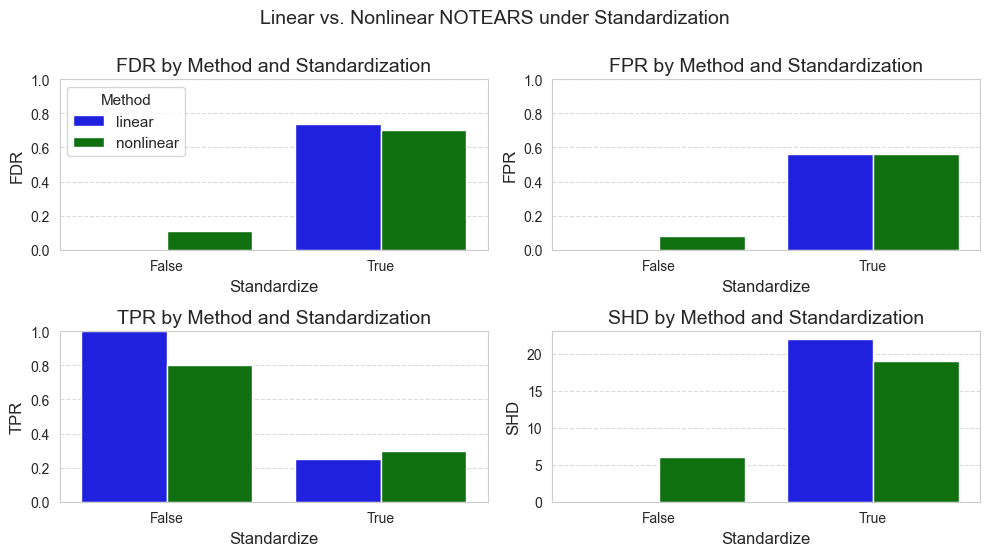

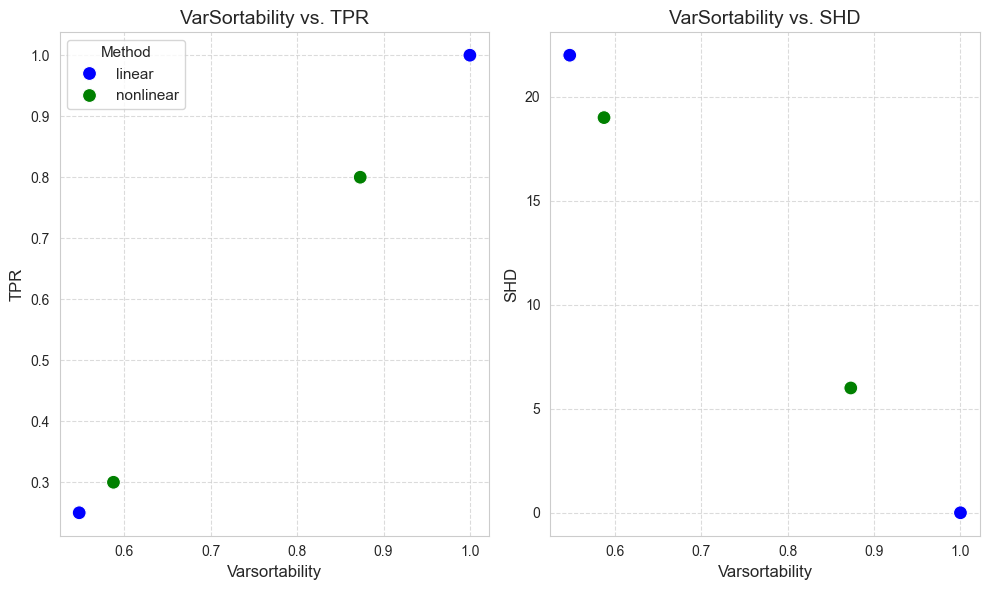

In [5]:
experiment2_1()


## <a id='3.2'>3.2 Experiment 2.2: Linear vs Nonlinear on Linear & Nonlinear Data</a>

In [6]:
def experiment2_2():
    """
    Experiment 2.2: Compare performance of Linear vs. Nonlinear NOTEARS
    on linear and nonlinear data generated from different SEMs.
    """
    print("\n--- Experiment 2.2: Performance Comparison ---")

    d=10
    s0=20
    graph_type="ER"
    n=1000
    noise_scale=1.0
    standardize=False
    lambda1_linear=0.01
    lambda1_nonlinear=0.01
    lambda2_nonlinear=0.01
    threshold=0.3
    seed=42
    set_random_seed(seed)

    # Generate linear data
    B_bin_lin = simulate_dag(d, s0, graph_type)
    X_linear = simulate_linear_sem(B_bin_lin, n, sem_type="gauss", noise_scale=noise_scale)
    if standardize:
        X_linear = StandardScaler().fit_transform(X_linear)

    # Generate nonlinear data
    B_bin_nonlin = simulate_dag(d, s0, graph_type)
    X_nonlinear = simulate_nonlinear_sem(B_bin_nonlin, n, sem_type="mlp")
    if standardize:
        X_nonlinear = StandardScaler().fit_transform(X_nonlinear)

    # Linear NOTEARS on Linear Data
    W_lin_lin = notears_linear(X_linear, lambda1=lambda1_linear, loss_type="l2", w_threshold=0.0)
    W_bin_lin_lin = (np.abs(W_lin_lin) > threshold).astype(int)
    acc_lin_lin = count_accuracy(B_bin_lin, W_bin_lin_lin)

    # Linear NOTEARS on Nonlinear Data
    W_lin_nonlin = notears_linear(X_nonlinear, lambda1=lambda1_linear, loss_type="l2", w_threshold=0.0)
    W_bin_lin_nonlin = (np.abs(W_lin_nonlin) > threshold).astype(int)
    acc_lin_nonlin = count_accuracy(B_bin_nonlin, W_bin_lin_nonlin)

    # Nonlinear NOTEARS on Linear Data
    X_linear_32 = X_linear.astype(np.float32)
    model_nonlin_lin = NotearsMLP(dims=[d, 10, 1], bias=True)
    W_nonlin_lin = notears_nonlinear(
        model_nonlin_lin,
        X_linear_32,
        lambda1=lambda1_nonlinear,
        lambda2=lambda2_nonlinear,
        max_iter=100,
        h_tol=1e-8, rho_max=1e16, w_threshold=0.0
    )
    W_bin_nonlin_lin = (np.abs(W_nonlin_lin) > threshold).astype(int)
    acc_nonlin_lin = count_accuracy(B_bin_lin, W_bin_nonlin_lin)

    # Nonlinear NOTEARS on Nonlinear Data
    X_nonlinear_32 = X_nonlinear.astype(np.float32)
    model_nonlin_nonlin = NotearsMLP(dims=[d, 10, 1], bias=True)
    W_nonlin_nonlin = notears_nonlinear(
        model_nonlin_nonlin,
        X_nonlinear_32,
        lambda1=lambda1_nonlinear,
        lambda2=lambda2_nonlinear,
        max_iter=100,
        h_tol=1e-8, rho_max=1e16, w_threshold=0.0
    )
    W_bin_nonlin_nonlin = (np.abs(W_nonlin_nonlin) > threshold).astype(int)
    acc_nonlin_nonlin = count_accuracy(B_bin_nonlin, W_bin_nonlin_nonlin)

    # Results
    records = [
        {
            "data_type": "Linear Data",
            "method": "Linear NOTEARS",
            "fdr": acc_lin_lin["fdr"],
            "fpr": acc_lin_lin["fpr"],
            "tpr": acc_lin_lin["tpr"],
            "shd": acc_lin_lin["shd"]
        },
        {
            "data_type": "Linear Data",
            "method": "Nonlinear NOTEARS",
            "fdr": acc_nonlin_lin["fdr"],
            "fpr": acc_nonlin_lin["fpr"],
            "tpr": acc_nonlin_lin["tpr"],
            "shd": acc_nonlin_lin["shd"]
        },
        {
            "data_type": "Nonlinear Data",
            "method": "Linear NOTEARS",
            "fdr": acc_lin_nonlin["fdr"],
            "fpr": acc_lin_nonlin["fpr"],
            "tpr": acc_lin_nonlin["tpr"],
            "shd": acc_lin_nonlin["shd"]
        },
        {
            "data_type": "Nonlinear Data",
            "method": "Nonlinear NOTEARS",
            "fdr": acc_nonlin_nonlin["fdr"],
            "fpr": acc_nonlin_nonlin["fpr"],
            "tpr": acc_nonlin_nonlin["tpr"],
            "shd": acc_nonlin_nonlin["shd"]
        },
    ]

    df_results = pd.DataFrame(records)

    # Plot
    plot_experiment2_2(df_results, title="Exp_2_2.png")


--- Experiment 2.2: Performance Comparison ---


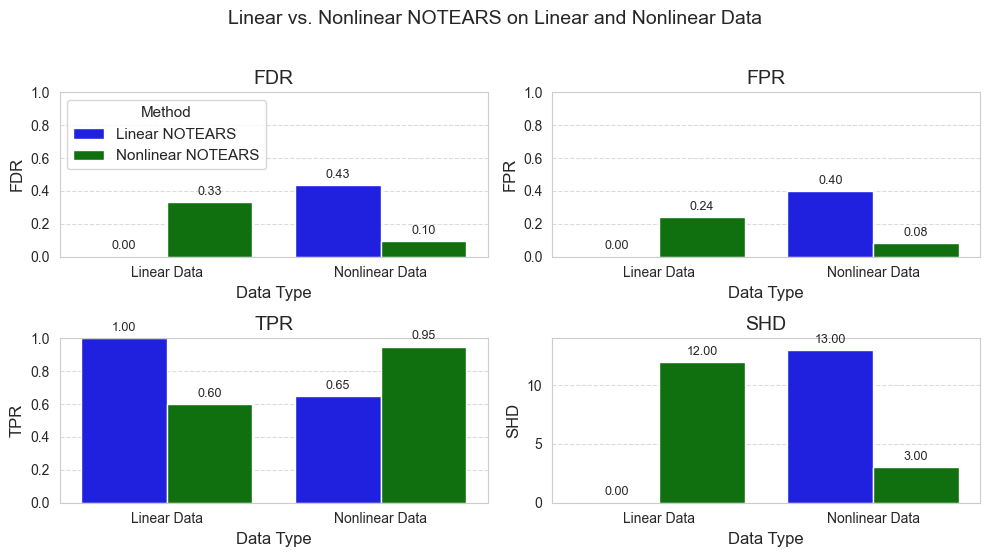

In [7]:
experiment2_2()

# <a id='4'>4. Experiment 3: Hyperparameter Assessment</a>
---

In [8]:
def experiment3():
    """
    Experiment 3: Run the hyperparameter assessment experiment
    """
    print("\n--- Experiment 3: Hyperparameter Assessment ---")
    
    d=10
    s0=20
    graph_type="ER"
    n=1000
    sem_type="gauss"
    noise_scale=1.0
    seed=42
    lambda1_values=np.logspace(-3, 0, 10)
    threshold_values=np.arange(0.1, 0.8, 0.05).tolist()
    fixed_lambda1=[0.01, 0.05, 0.1]
    fixed_threshold=[0.2, 0.4, 0.6]

    # Default hyperparameter grids
    if lambda1_values is None:
        lambda1_values = np.logspace(-3, 0, 10)
    if threshold_values is None:
        threshold_values = np.arange(0.1, 0.8, 0.05).tolist()
    if fixed_lambda1 is None:
        fixed_lambda1 = [0.01, 0.1]
    if fixed_threshold is None:
        fixed_threshold = [0.3, 0.5]
    set_random_seed(seed)
    B_bin = simulate_dag(d, s0, graph_type)
    X = simulate_linear_sem(B_bin, n, sem_type=sem_type, noise_scale=noise_scale)

    # Scenario A: Vary lambda1, fix thresholds
    results_fix_thr = []
    for thr in fixed_threshold:
        for lam in lambda1_values:
            W_est_lin = notears_linear(X, lambda1=lam, loss_type="l2", w_threshold=0.0)
            W_bin_lin = (np.abs(W_est_lin) > thr).astype(int)
            acc_lin = count_accuracy(B_bin, W_bin_lin)
            results_fix_thr.append({
                "lambda1": lam,
                "threshold": thr,
                "tpr": acc_lin["tpr"],
                "shd": acc_lin["shd"]
            })

    df_fix_thr = pd.DataFrame(results_fix_thr)

    # Scenario B: Vary threshold, fix lambda1
    results_fix_lam = []
    for lam in fixed_lambda1:
        for thr in threshold_values:
            W_est_lin = notears_linear(X, lambda1=lam, loss_type="l2", w_threshold=0.0)
            W_bin_lin = (np.abs(W_est_lin) > thr).astype(int)
            acc_lin = count_accuracy(B_bin, W_bin_lin)
            results_fix_lam.append({
                "threshold": thr,
                "lambda1": lam,
                "tpr": acc_lin["tpr"],
                "shd": acc_lin["shd"]
            })

    df_fix_lam = pd.DataFrame(results_fix_lam)
    plot_experiment3(df_fix_thr, df_fix_lam)


--- Experiment 3: Hyperparameter Assessment ---

--- Generating Plots ---


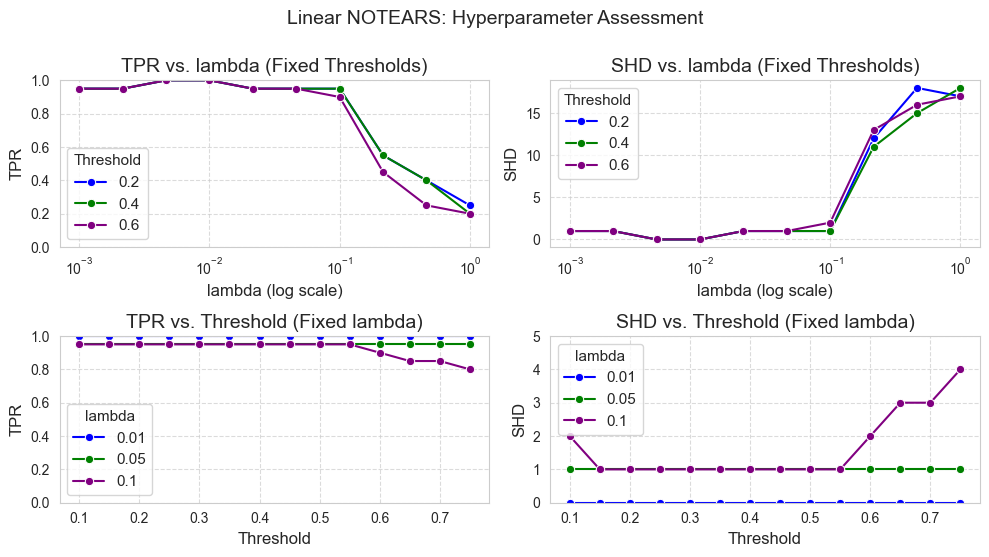

In [9]:
experiment3()